# Sales Growth Over Time – OLAP Analysis

## Project Goal

**How is sales revenue changing over time, and are there any seasonal or monthly patterns we can identify?**

This analysis focuses on identifying sales growth trends, seasonal spikes, and product/region-specific performance using both Power BI and Python.

---

## Tools Used

- **Power BI** – for drag-and-drop OLAP visualizations, slicing, dicing, and drilldowns
- **Python (Pandas, Seaborn, Matplotlib)** – for scripted visualizations, transformations, and deeper validation
- **SQLite** – data warehouse backend for storing sales data
- **Jupyter Notebooks / VS Code** – to write and test Python queries and visuals

---

## Data Overview

Tables used:
- `sale` – Sales data (amounts, dates, product/customer IDs)
- `customer` – Customer information including region
- `product` – Product details including category

Note: ProductID in the `sale` table had an offset of +100, which we adjusted to join correctly with the `product` table.

---

## Step-by-Step Process

### 1. Prepare the Data

```python
import pandas as pd
import sqlite3

conn = sqlite3.connect('../data/dw/smart_sales.db')

df = pd.read_sql_query("""
SELECT 
    s.SaleAmount, 
    s.SaleDate, 
    c.Region, 
    p.Category,
    c.Name AS CustomerName,
    s.PaymentType
FROM sale s
LEFT JOIN customer c ON s.CustomerID = c.CustomerID
LEFT JOIN product p ON (s.ProductID - 100) = p.ProductID
""", conn)


# Load Data

In [24]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('../data/dw/smart_sales.db')

# Just the sales table, no joins
df_test = pd.read_sql_query("SELECT * FROM sale LIMIT 10", conn)
df_test.head()


,TransactionID,SaleDate,CustomerID,ProductID,StoreID,CampaignID,SaleAmount,DiscountPercent,PaymentType
0,1,2024-01-06,1008,102,404,0,39.10,5.0,Credit
1,2,2024-01-06,1009,105,403,0,19.78,10.0,Debit
2,3,2024-01-16,1004,107,404,0,335.10,0.0,Debit
3,4,2024-01-29,1009,104,403,0,172.40,0.0,Cash
4,5,2024-02-06,1002,102,402,0,312.80,5.0,Cash


In [25]:
# Join with customer only
df_customer_join = pd.read_sql_query("""
SELECT s.SaleAmount, s.SaleDate, c.Region
FROM sale s
JOIN customer c ON s.CustomerID = c.CustomerID
LIMIT 10
""", conn)

print("Customer join rows:", len(df_customer_join))
display(df_customer_join)


Customer join rows: 10


,SaleAmount,SaleDate,Region
0,39.10,2024-01-06,North
1,19.78,2024-01-06,West
2,335.10,2024-01-16,West
3,172.40,2024-01-29,West
4,312.80,2024-02-06,East
5,622.86,2024-02-06,East
6,469.14,2024-02-06,North
7,67.02,2024-02-08,South
8,469.14,2024-02-09,West
9,138.46,2024-02-09,East


In [26]:
# Join with product only
df_product_join = pd.read_sql_query("""
SELECT s.SaleAmount, s.SaleDate, p.Category
FROM sale s
JOIN product p ON s.ProductID = p.ProductID
LIMIT 10
""", conn)

print("Product join rows:", len(df_product_join))
display(df_product_join)


Product join rows: 0


,SaleAmount,SaleDate,Category


In [27]:
# Get unique ProductIDs from sale table
sale_products = pd.read_sql_query("SELECT DISTINCT ProductID FROM sale", conn)
print("ProductIDs in sale table:")
print(sale_products.head())

# Get unique ProductIDs from product table
product_ids = pd.read_sql_query("SELECT DISTINCT ProductID FROM product", conn)
print("ProductIDs in product table:")
print(product_ids.head())


ProductIDs in sale table:
   ProductID
0        102
1        105
2        107
3        104
4        106
ProductIDs in product table:
   ProductID
0          1
1          2
2          3
3          4
4          5


In [28]:
import pandas as pd
import sqlite3

# Connect to SQLite
conn = sqlite3.connect('../data/dw/smart_sales.db')

# Load basic sales data (with join to customer and product, no derived date fields)
df = pd.read_sql_query("""
SELECT 
    s.SaleAmount, 
    s.SaleDate, 
    c.Region, 
    p.Category,
    s.CustomerID,
    s.ProductID
FROM sale s
LEFT JOIN customer c ON s.CustomerID = c.CustomerID
LEFT JOIN product p ON (s.ProductID - 100) = p.ProductID
""", conn)

# Convert SaleDate to datetime
df['SaleDate'] = pd.to_datetime(df['SaleDate'])

# Derive Year, Quarter, Month Name
df['Year'] = df['SaleDate'].dt.year
df['Quarter'] = df['SaleDate'].dt.to_period('Q').astype(str)
df['Month Name'] = df['SaleDate'].dt.strftime('%B')

print(f"Loaded {len(df)} rows")
df.head()


Loaded 47 rows


,SaleAmount,SaleDate,Region,Category,CustomerID,ProductID,Year,Quarter,Month Name
0,39.10,2024-01-06,North,Clothing,1008,102,2024,2024Q1,January
1,19.78,2024-01-06,West,Clothing,1009,105,2024,2024Q1,January
2,335.10,2024-01-16,West,None,1004,107,2024,2024Q1,January
3,172.40,2024-01-29,West,Electronics,1009,104,2024,2024Q1,January
4,312.80,2024-02-06,East,Clothing,1002,102,2024,2024Q1,February


In [31]:
# Load just the sale and product IDs for validation
sale_ids = pd.read_sql_query("SELECT DISTINCT ProductID FROM sale", conn)
product_ids = pd.read_sql_query("SELECT DISTINCT ProductID FROM product", conn)

print("Sale ProductIDs:", sale_ids['ProductID'].sort_values().unique())
print("Product Table ProductIDs:", product_ids['ProductID'].sort_values().unique())

# Now adjust and test matches
sale_ids['AdjustedID'] = sale_ids['ProductID'] - 100
matched = sale_ids[sale_ids['AdjustedID'].isin(product_ids['ProductID'])]

print(f"\nMatched rows after adjustment: {len(matched)} out of {len(sale_ids)}")


Sale ProductIDs: [101 102 103 104 105 106 107 108]
Product Table ProductIDs: [1 2 3 4 5 6]

Matched rows after adjustment: 6 out of 8


In [32]:
df = pd.read_sql_query("""
SELECT 
    s.SaleAmount, 
    s.SaleDate, 
    c.Region, 
    p.Category,
    strftime('%Y', s.SaleDate) AS Year,
    strftime('%m', s.SaleDate) AS Month,
    strftime('%m', s.SaleDate) AS MonthNumber
FROM sale s
LEFT JOIN customer c ON s.CustomerID = c.CustomerID
LEFT JOIN product p ON (s.ProductID - 100) = p.ProductID
""", conn)

df['Month'] = df['Month'].astype(int)
df['Year'] = df['Year'].astype(int)
df.head()


,SaleAmount,SaleDate,Region,Category,Year,Month,MonthNumber
0,39.10,2024-01-06,North,Clothing,2024,1,01
1,19.78,2024-01-06,West,Clothing,2024,1,01
2,335.10,2024-01-16,West,None,2024,1,01
3,172.40,2024-01-29,West,Electronics,2024,1,01
4,312.80,2024-02-06,East,Clothing,2024,2,02


# Monthly Sales Growth

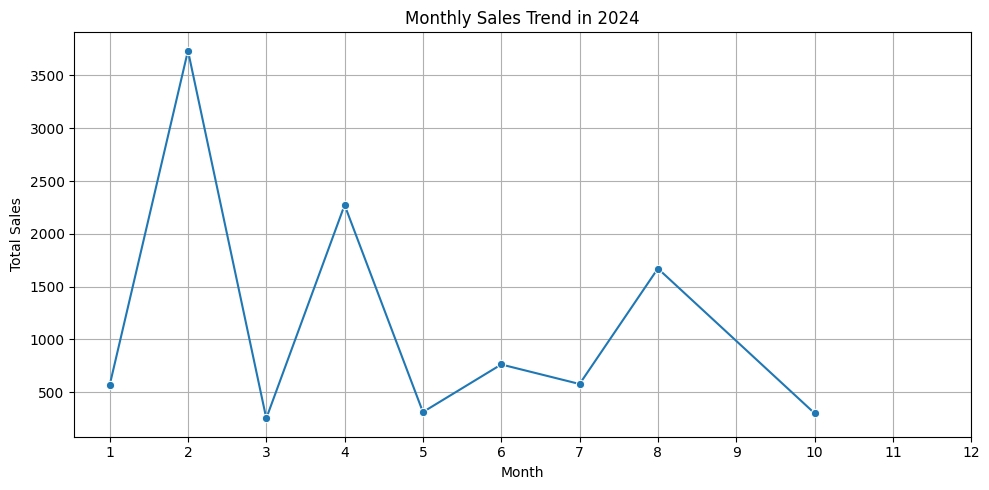

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for 2024 only
df_2024 = df[df['Year'] == 2024]

# Group and summarize
monthly_sales = df_2024.groupby(['Month'])['SaleAmount'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Month')

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='Month', y='SaleAmount', marker='o')
plt.title("Monthly Sales Trend in 2024")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import sqlite3

# Update this path to your actual smart_sales.db file location
conn = sqlite3.connect('C:\Projects\smart-store-foster-1\data\dw\smart_sales.db')

# Adjusted query with ProductID offset fix and date extraction
df = pd.read_sql_query("""
SELECT 
    s.SaleAmount, 
    s.SaleDate, 
    c.Region, 
    p.Category,
    strftime('%Y', s.SaleDate) AS Year,
    strftime('%m', s.SaleDate) AS MonthNumber,
    strftime('%Y-%m', s.SaleDate) AS YearMonth
FROM sale s
LEFT JOIN customer c ON s.CustomerID = c.CustomerID
LEFT JOIN product p ON (s.ProductID - 100) = p.ProductID
""", conn)

# Convert SaleDate to datetime
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['MonthNumber'] = df['MonthNumber'].astype(int)

# Filter for 2024
df_2024 = df[df['Year'] == '2024']
df_2024.head()


<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\linds\AppData\Local\Temp\ipykernel_9316\4280468239.py:5: SyntaxWarning: invalid escape sequence '\P'
  conn = sqlite3.connect('C:\Projects\smart-store-foster-1\data\dw\smart_sales.db')


,SaleAmount,SaleDate,Region,Category,Year,MonthNumber,YearMonth
0,39.10,2024-01-06,North,Clothing,2024,1,2024-01
1,19.78,2024-01-06,West,Clothing,2024,1,2024-01
2,335.10,2024-01-16,West,None,2024,1,2024-01
3,172.40,2024-01-29,West,Electronics,2024,1,2024-01
4,312.80,2024-02-06,East,Clothing,2024,2,2024-02


# Group by Month + Region to Track Growth

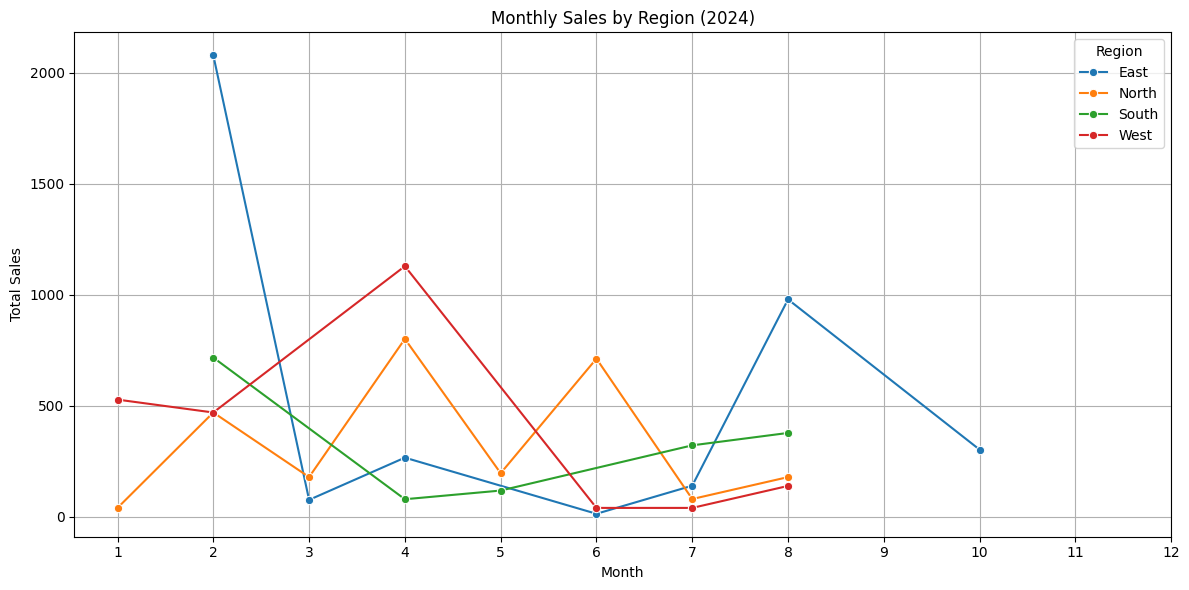

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by month and region
monthly_region_sales = df_2024.groupby(['Region', 'MonthNumber'])['SaleAmount'].sum().reset_index()

# Sort months
monthly_region_sales['MonthNumber'] = monthly_region_sales['MonthNumber'].astype(int)

# Plot it
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_region_sales, x='MonthNumber', y='SaleAmount', hue='Region', marker='o')

plt.title('Monthly Sales by Region (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Sales by Product Category Growth

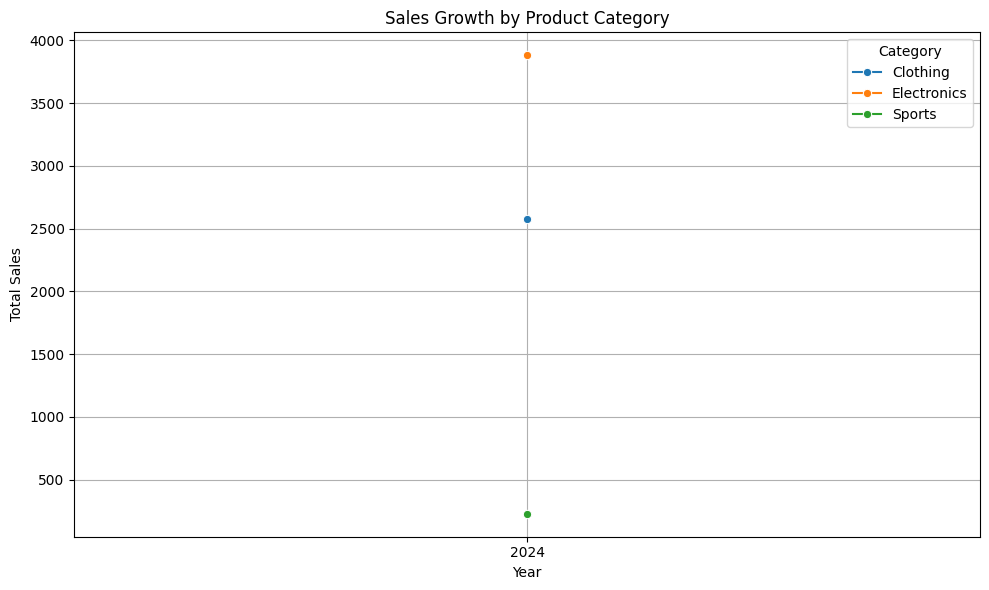

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group sales by Year and Product Category
category_growth = df.groupby(['Year', 'Category'])['SaleAmount'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=category_growth, x='Year', y='SaleAmount', hue='Category', marker="o")
plt.title('Sales Growth by Product Category')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


# by month

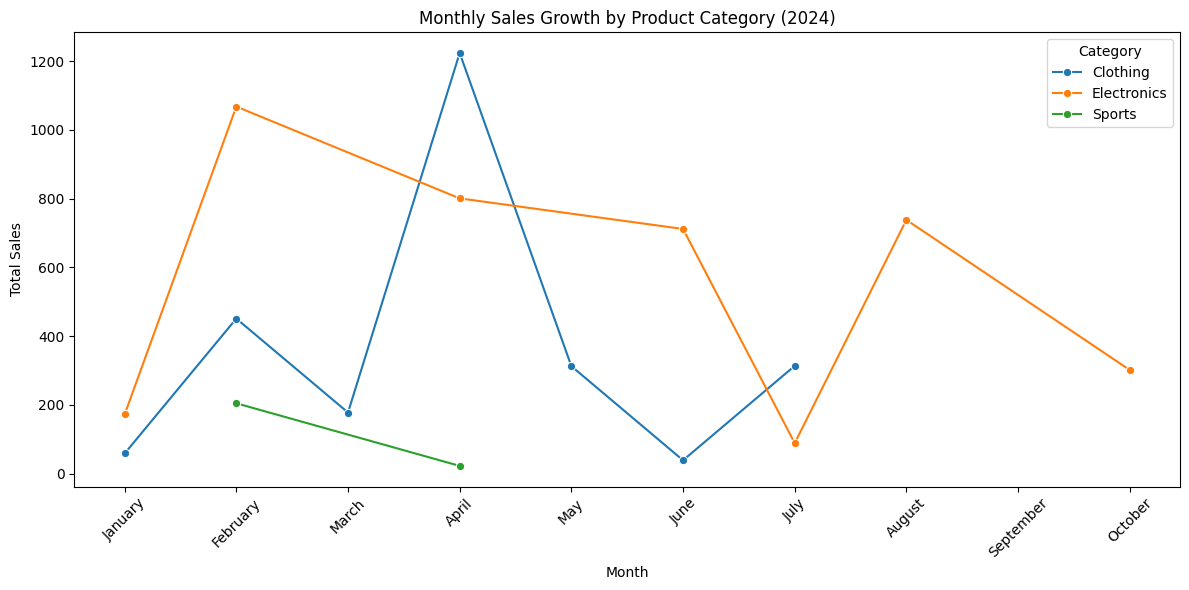

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure SaleDate is in datetime format
df['SaleDate'] = pd.to_datetime(df['SaleDate'])

# Extract Year, Month Number, Month Name, Quarter
df['Year'] = df['SaleDate'].dt.year
df['Month'] = df['SaleDate'].dt.month
df['Month Name'] = df['SaleDate'].dt.strftime('%B')  # Full month name
df['Quarter'] = df['SaleDate'].dt.quarter

# Filter for 2024 only
df_2024 = df[df['Year'] == 2024].copy()

# Create a custom month order to sort the x-axis properly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Group by Month Name and Category
monthly_category_sales = df_2024.groupby(['Month Name', 'Category'])['SaleAmount'].sum().reset_index()

# Set Month Name as a categorical variable with the correct order
monthly_category_sales['Month Name'] = pd.Categorical(
    monthly_category_sales['Month Name'], categories=month_order, ordered=True
)

# Sort by Month Name
monthly_category_sales.sort_values('Month Name', inplace=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_category_sales, x='Month Name', y='SaleAmount', hue='Category', marker='o')
plt.title('Monthly Sales Growth by Product Category (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Growth Month to Month

In [42]:
# Ensure month names are ordered properly for sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_2024['Month Name'] = pd.Categorical(df_2024['Month Name'], categories=month_order, ordered=True)

# Group by Month and Category
monthly_sales = df_2024.groupby(['Category', 'Month Name'])['SaleAmount'].sum().reset_index()

# Sort by Category and Month
monthly_sales.sort_values(['Category', 'Month Name'], inplace=True)

# Calculate % Growth
monthly_sales['% Growth'] = monthly_sales.groupby('Category')['SaleAmount'].pct_change() * 100

# Round for readability
monthly_sales['% Growth'] = monthly_sales['% Growth'].round(2)

# Display the result
print(monthly_sales)


       Category Month Name  SaleAmount  % Growth
0      Clothing    January       58.88       NaN
1      Clothing   February      451.26    666.41
2      Clothing      March      178.02    -60.55
3      Clothing      April     1223.68    587.38
4      Clothing        May      312.80    -74.44
5      Clothing       June       39.10    -87.50
6      Clothing       July      313.72    702.35
7      Clothing     August        0.00   -100.00
8      Clothing  September        0.00       NaN
9      Clothing    October        0.00       NaN
10     Clothing   November        0.00       NaN
11     Clothing   December        0.00       NaN
12  Electronics    January      172.40       NaN
13  Electronics   February     1067.76    519.35
14  Electronics      March        0.00   -100.00
15  Electronics      April      800.82       inf
16  Electronics        May        0.00   -100.00
17  Electronics       June      711.84       inf
18  Electronics       July       88.98    -87.50
19  Electronics     

C:\Users\linds\AppData\Local\Temp\ipykernel_9316\4248210033.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_sales = df_2024.groupby(['Category', 'Month Name'])['SaleAmount'].sum().reset_index()


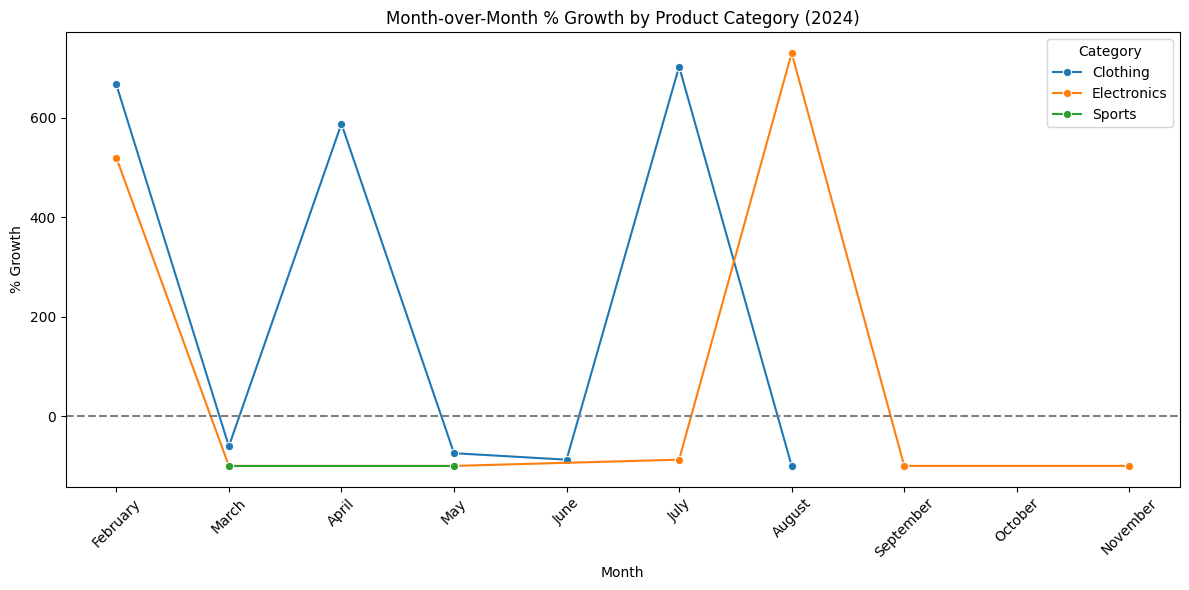

In [43]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month Name', y='% Growth', hue='Category', marker='o')
plt.title('Month-over-Month % Growth by Product Category (2024)')
plt.xlabel('Month')
plt.ylabel('% Growth')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0%
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# MoM % Growth by Region

In [44]:
# Step 1: Make sure month names are properly ordered
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_2024['Month Name'] = pd.Categorical(df_2024['Month Name'], categories=month_order, ordered=True)

# Step 2: Group by Region and Month
monthly_region_sales = df_2024.groupby(['Region', 'Month Name'])['SaleAmount'].sum().reset_index()

# Step 3: Sort for consistent growth calculation
monthly_region_sales.sort_values(['Region', 'Month Name'], inplace=True)

# Step 4: Calculate % Growth per Region
monthly_region_sales['% Growth'] = monthly_region_sales.groupby('Region')['SaleAmount'].pct_change() * 100
monthly_region_sales['% Growth'] = monthly_region_sales['% Growth'].round(2)

# Preview
print(monthly_region_sales.head(12))


   Region Month Name  SaleAmount  % Growth
0    East    January        0.00       NaN
1    East   February     2079.42       inf
2    East      March       75.36    -96.38
3    East      April      265.64    252.49
4    East        May        0.00   -100.00
5    East       June       12.56       inf
6    East       July      139.22   1008.44
7    East     August      978.94    603.16
8    East  September        0.00   -100.00
9    East    October      301.70       inf
10   East   November        0.00   -100.00
11   East   December        0.00       NaN


C:\Users\linds\AppData\Local\Temp\ipykernel_9316\788250704.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_region_sales = df_2024.groupby(['Region', 'Month Name'])['SaleAmount'].sum().reset_index()


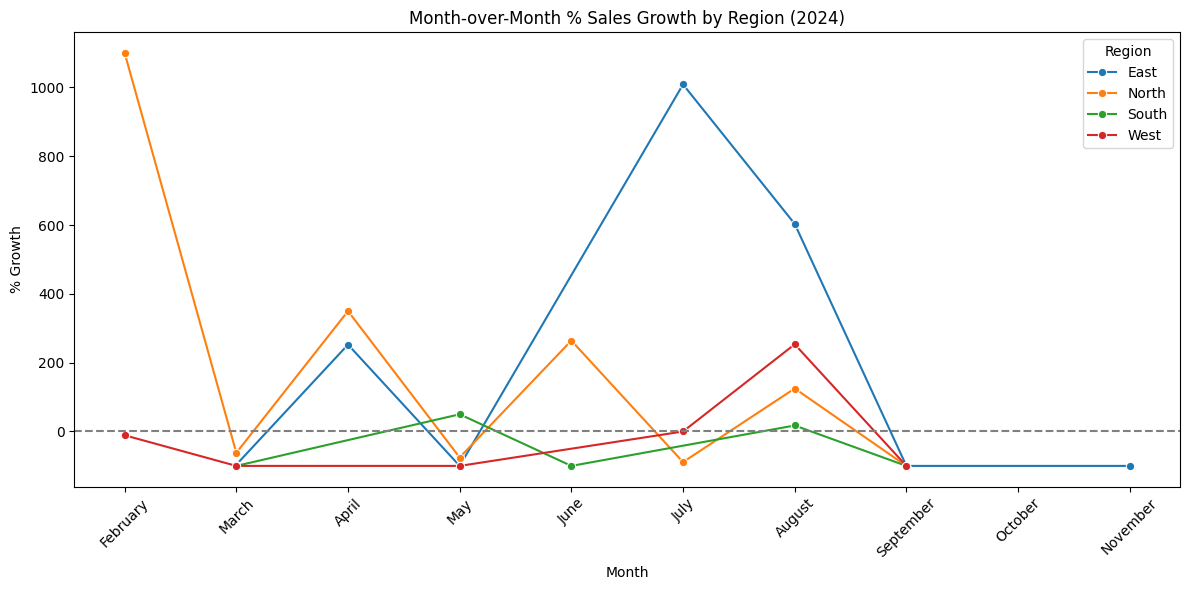

In [45]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_region_sales, x='Month Name', y='% Growth', hue='Region', marker='o')
plt.title('Month-over-Month % Sales Growth by Region (2024)')
plt.xlabel('Month')
plt.ylabel('% Growth')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0%
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Sale Date

In [34]:
import pandas as pd
import sqlite3

# Load data
conn = sqlite3.connect('../data/dw/smart_sales.db')
df = pd.read_sql_query("""
SELECT s.SaleAmount, s.SaleDate, c.Region, p.Category
FROM sale s
JOIN customer c ON s.CustomerID = c.CustomerID
JOIN product p ON s.ProductID = p.ProductID
""", conn)

# Convert to datetime
df['SaleDate'] = pd.to_datetime(df['SaleDate'], errors='coerce')

# Create date parts
df['Year'] = df['SaleDate'].dt.year
df['Quarter'] = df['SaleDate'].dt.to_period('Q').astype(str)
df['Month Name'] = df['SaleDate'].dt.strftime('%B')

df.head()


,SaleAmount,SaleDate,Region,Category,Year,Quarter,Month Name


# Monthly sales by region

C:\Users\linds\AppData\Local\Temp\ipykernel_9316\2590668643.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_region_sales = df_2024.groupby(['Region', 'Month Name'])['SaleAmount'].sum().reset_index()


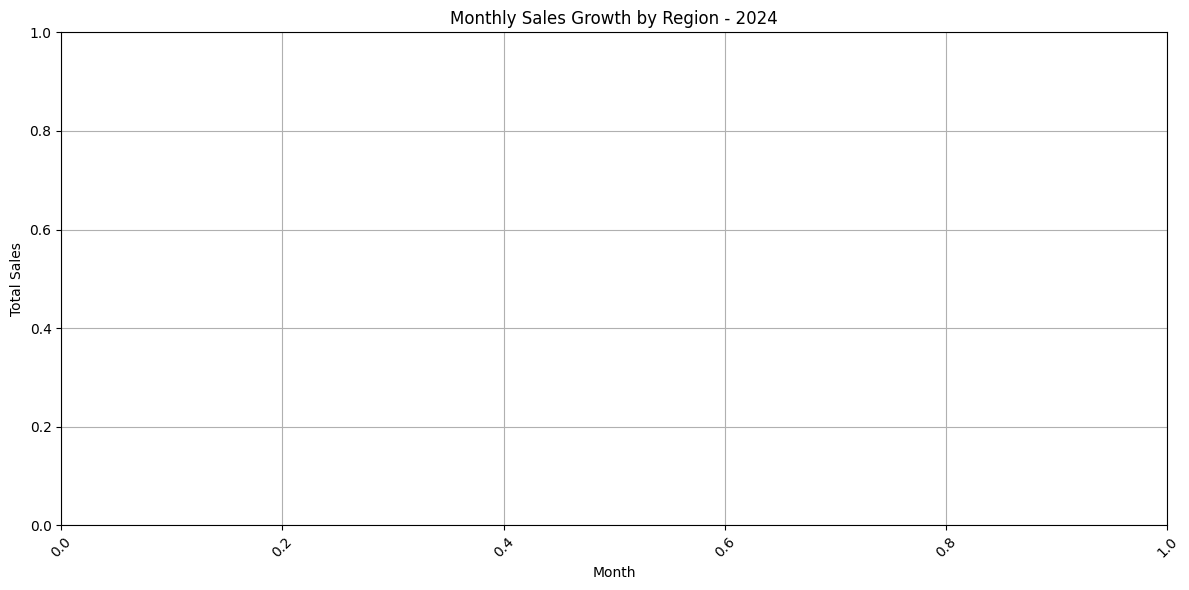

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connect to your SQLite database
conn = sqlite3.connect('../data/dw/smart_sales.db')

# Read sales + customer + product data (no Year, Quarter in table, so calculate from SaleDate)
df = pd.read_sql_query("""
SELECT s.SaleAmount, s.SaleDate, c.Region, p.Category, c.Name AS CustomerName, s.PaymentType
FROM sale s
JOIN customer c ON s.CustomerID = c.CustomerID
JOIN product p ON s.ProductID = p.ProductID
""", conn)

# Convert SaleDate to datetime
df['SaleDate'] = pd.to_datetime(df['SaleDate'])

# Filter for only 2024
df_2024 = df[(df['SaleDate'] >= '2024-01-01') & (df['SaleDate'] <= '2024-12-31')]

# Extract month name
df_2024['Month Name'] = df_2024['SaleDate'].dt.strftime('%B')

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_2024['Month Name'] = pd.Categorical(df_2024['Month Name'], categories=month_order, ordered=True)

# Group total sales by Region and Month
monthly_region_sales = df_2024.groupby(['Region', 'Month Name'])['SaleAmount'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_region_sales, x='Month Name', y='SaleAmount', hue='Region', marker='o')
plt.title('Monthly Sales Growth by Region - 2024')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Do certain product categories drive most of the growth?

In [13]:
category_year = df.groupby(['Category', 'Year'])['SaleAmount'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=category_year, x='Year', y='SaleAmount', hue='Category', marker='o')
plt.title('Sales Growth by Product Category Over Years')
plt.ylabel('Total Sales')
plt.xlabel('Year')
plt.grid(True)
plt.show()


KeyError: 'Year'

# Are there seasonal spikes in sales (e.g., Q4)?

In [ ]:
quarterly = df.groupby('Quarter')['SaleAmount'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=quarterly, x='Quarter', y='SaleAmount')
plt.title('Sales by Quarter (All Years Combined)')
plt.ylabel('Total Sales')
plt.xlabel('Quarter')
plt.grid(True, axis='y')
plt.show()


# What months had the highest/lowest sales in 2023?

In [ ]:
sales_2023 = df[df['Year'] == 2023]
monthly_2023 = sales_2023.groupby('Month Name')['SaleAmount'].sum().reset_index()

# Optional: to order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_2023['Month Name'] = pd.Categorical(monthly_2023['Month Name'], categories=month_order, ordered=True)
monthly_2023 = monthly_2023.sort_values('Month Name')

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_2023, x='Month Name', y='SaleAmount', palette='viridis')
plt.title('Monthly Sales in 2023')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.grid(True, axis='y')
plt.show()


Bar Chart

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and plot: Total Sales by Month
monthly_sales = df.groupby("Month Name")["SaleAmount"].sum().reset_index()

# Sort months if needed
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
monthly_sales["Month Name"] = pd.Categorical(monthly_sales["Month Name"], categories=month_order, ordered=True)
monthly_sales = monthly_sales.sort_values("Month Name")

# Plot
sns.barplot(data=monthly_sales, x="Month Name", y="SaleAmount", palette="Blues_d")
plt.xticks(rotation=45)
plt.title("Total Sales by Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()
